# 2nd milestone

In [1]:
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Activation, BatchNormalization, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Flatten
import numpy as np
import scipy as sp
from skimage import color
import warnings
import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pandas as pd

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Starting info

I started from this paper: <b>Colorful image colorization - Richard Zhang, Phillip Isola, Alexei A. Efros</b>
https://arxiv.org/pdf/1603.08511.pdf

In short they found out, that image colorization problem considered as a multinomial classification problem give better results than the other older solutions for this problem. Because of that, they first turned the RGB pixels into LAB colorspace. In this colorspace, the colorisation problem can be interpreted as input = L, output = a,b.  
First they created an RGB distribution ->  RGB(a,b|L = 50)
![RGB distribution](img_for_description/rgb_distribution.png)  
  
After that they discretize the values, with this method they got 313 class which are different pixels. This discretized list is saved to numpy pts_hull_file, it is a 2 dimensional with shape of (313,2) where the axis 1 refers to a,b pairs.
I'm using up this array, in my function D which map all of the pixel=(L1,a1,b1) to a one hot encoded vector with shape (313,).   This D decide where this pixel belong from the discretized values, after that encode to one hot vector.


https://en.wikipedia.org/wiki/CIELAB_color_space  
  
### Comments for the below code

    - Image folder is where all of you data is, you have to change to your filepath, where is your samples.

    - Pts_hull_file is the discrete class array, which are created from RGB-LAB distribution. You don't have to recreate, it is in the repo/samples folder.
    
    - ImageLoader class will hold the prepared data for the training and evaluation.
    - img_loader.separate_small_data(valid_split,test_split) prepares the data to train.


In [2]:
# Import own .py files
import data_collector
import image_loader
import nnetwork
from utility_methods import save_plots
from importlib import reload  # Python 3.4+ only.
nnetwork = reload(nnetwork)
import gc


def teszt():
    gc.collect()
    image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
    pts_hull_file = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/pts_in_hull.npy'

    img_loader = image_loader.ImageLoader(image_folder, pt_in_hull_folder = pts_hull_file)

    # Separate_small_data(validation_rate, test_rate)
    img_loader.separate_small_data(0.1,0.1)
    return img_loader

O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
O:\ProgrammingSoftwares\anaconda_projects\dp_nagyhazi\src\utility_methods.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\ipykernel\

In [3]:
#%load_ext memory_profiler
img_loader = teszt()

Length of image list:  27


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Gigabyte of dataset:  0.03028106689453125
Gigabyte of y_dataset:  0.0018925666809082031


O:\ProgrammingSoftwares\anaconda3\envs\tensor-cpu\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Info for the below code.

I've created the first model, which built up from a vgg16 keras model and after it batch norm and some convolution layers. These last convolution layers are responsible to convert the collected features into an a,b discretized distribution. Becuase of multinomial classification i thought the categorical crossentropy will be the best for me.

In [28]:
nnetwork = reload(nnetwork)
model = nnetwork.create_vgg_model(1,8)
model.compile('adam', loss = 'categorical_crossentropy',
              metrics=['accuracy', keras.metrics.categorical_accuracy])

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_____________________________

In [6]:
patience=50
early_stopping=EarlyStopping(monitor='val_acc',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5', monitor='val_acc', save_best_only=True, verbose=1)

In [10]:
history = model.fit(x=img_loader.X_train,
                    y=img_loader.Y_train,
                    batch_size=16,
                    epochs=30,
                    validation_data=(img_loader.X_valid,img_loader.Y_valid),
                   callbacks=[checkpointer, early_stopping])

Train on 19 samples, validate on 2 samples
Epoch 1/30
19/19 [==============================] - 18s 943ms/step - loss: 5.8294 - acc: 0.0218 - categorical_accuracy: 0.0218 - val_loss: 2.9713 - val_acc: 0.4960 - val_categorical_accuracy: 0.4960

Epoch 00001: val_acc improved from -inf to 0.49601, saving model to weights.hdf5
Epoch 2/30
19/19 [==============================] - 17s 891ms/step - loss: 3.7136 - acc: 0.3767 - categorical_accuracy: 0.3767 - val_loss: 2.2060 - val_acc: 0.4960 - val_categorical_accuracy: 0.4960

Epoch 00002: val_acc did not improve from 0.49601
Epoch 3/30
19/19 [==============================] - 16s 867ms/step - loss: 2.9820 - acc: 0.3784 - categorical_accuracy: 0.3784 - val_loss: 2.3980 - val_acc: 0.1298 - val_categorical_accuracy: 0.1298

Epoch 00003: val_acc did not improve from 0.49601
Epoch 4/30
19/19 [==============================] - 16s 857ms/step - loss: 2.9390 - acc: 0.2890 - categorical_accuracy: 0.2890 - val_loss: 2.2196 - val_acc: 0.1317 - val_catego

In [11]:
score = model.evaluate(img_loader.X_test, img_loader.Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3/3 [==============================] - 2s 564ms/step
Test loss: 2.9197821617126465
Test accuracy: 0.2089710831642151


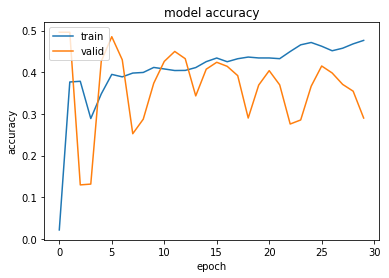

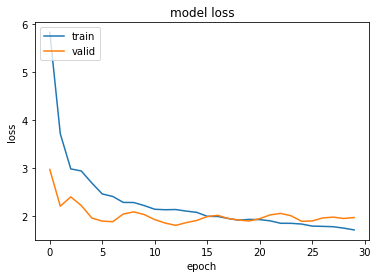

In [12]:
save_plots(history)

Changing the <b>idx</b> you can try out what did the network do.

(224, 224, 3)
(1, 56, 56, 2)
(224, 224, 3)
(1, 56, 56, 2)


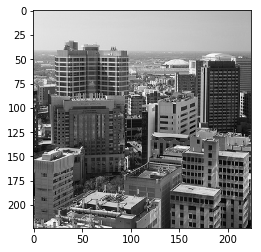

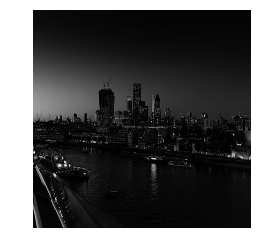

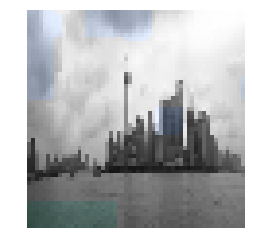

In [31]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline



for idx in range(len(img_loader.X_valid)):
    rgb_im = img_loader.X_valid[idx]
    plt.imshow(rgb_im)
    print(rgb_im.shape)
    plt.figure()
    y_real = model.predict(img_loader.X_train[idx].reshape((1,224,224,3)))
    y_real = np.apply_along_axis(lambda x: img_loader.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)
    img_loader.pts_in_hull # létező színosztályok
    print(y_real.shape)
    lab_im = np.concatenate([img_loader.y_dataset[np.newaxis,idx,:,:,0, np.newaxis],y_real ], axis=3)
    rgb_im = color.lab2rgb(lab_im[0])
    plt.imshow(rgb_im)
    plt.axis('off')
    #plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')

In [60]:
test_weights = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/2/weights.hdf5'
root_pictures = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/2/test_pics/'
log_path = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/2/training1.log'
saveplot_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/2/'
model = keras.models.load_model(test_weights)

In [61]:
from keras.callbacks import EarlyStopping, LambdaCallback,ModelCheckpoint, CSVLogger
from utility_methods import collect_and_separate_labels, collect_labels,save_plots, save_plots_callback
import streaming_data
streaming_data = reload(streaming_data)
image_folder = 'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/samples/images/'
patience=15
early_stopping=EarlyStopping(monitor='loss',patience=patience, verbose=1)
checkpointer=ModelCheckpoint(filepath='weights.hdf5',monitor='loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger('training.log', append=True)
traain = streaming_data.StreamingDataGenerator(image_folder,batch_size=16)


Length of image list:  28


In [58]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
history = model.fit_generator(generator=traain,
                    validation_data=traain,
                    epochs=30,
                    callbacks=[csv_logger,checkpointer, early_stopping])

Epoch 1/30
1/1 [==============================] - 47s 47s/step - loss: 3.5518 - acc: 0.3540 - categorical_accuracy: 0.3540 - val_loss: 3.1699 - val_acc: 0.3846 - val_categorical_accuracy: 0.3846

Epoch 00001: loss improved from inf to 3.55176, saving model to weights.hdf5
Epoch 2/30
1/1 [==============================] - 37s 37s/step - loss: 3.1699 - acc: 0.3846 - categorical_accuracy: 0.3846 - val_loss: 2.9383 - val_acc: 0.3920 - val_categorical_accuracy: 0.3920

Epoch 00002: loss improved from 3.55176 to 3.16992, saving model to weights.hdf5
Epoch 3/30
1/1 [==============================] - 40s 40s/step - loss: 2.9383 - acc: 0.3920 - categorical_accuracy: 0.3920 - val_loss: 2.7753 - val_acc: 0.4039 - val_categorical_accuracy: 0.4039

Epoch 00003: loss improved from 3.16992 to 2.93830, saving model to weights.hdf5
Epoch 4/30
1/1 [==============================] - 45s 45s/step - loss: 2.7753 - acc: 0.4039 - categorical_accuracy: 0.4039 - val_loss: 2.6267 - val_acc: 0.4064 - val_categor

KeyboardInterrupt: 

Length of image list:  28
XMAX 151.6551409600218


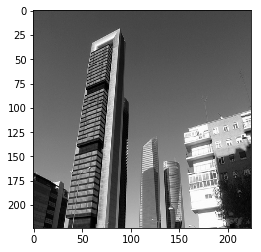

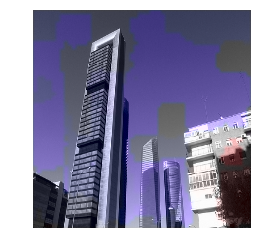

XMAX 93.93227593332048


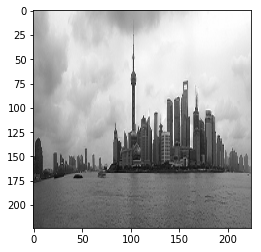

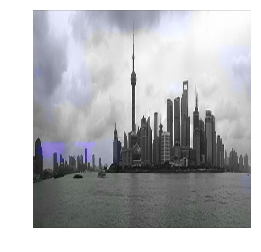

XMAX 168.2106145186462


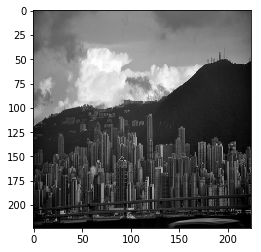

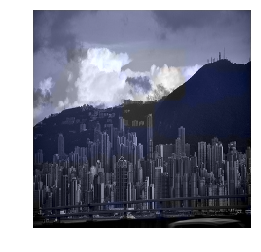

XMAX 130.40438192575579


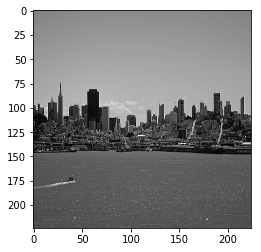

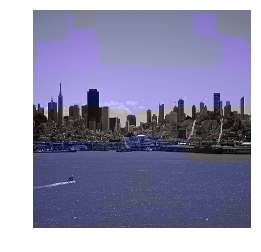

XMAX 168.285409650472


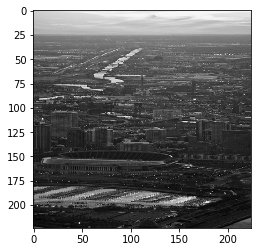

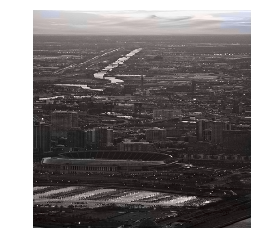

XMAX 113.5305139021485


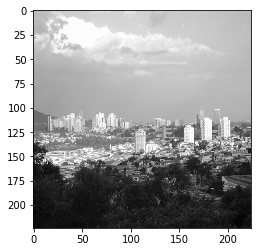

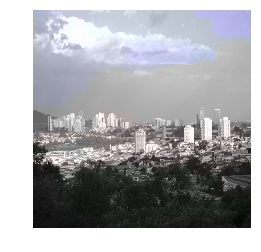

XMAX 203.45496302018282


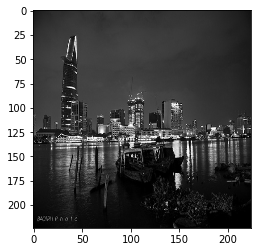

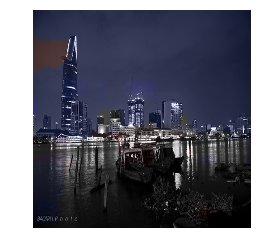

XMAX 174.08313205131597


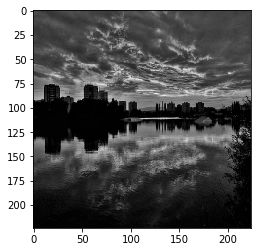

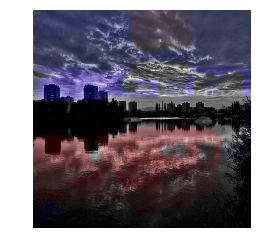

XMAX 117.17121987213031


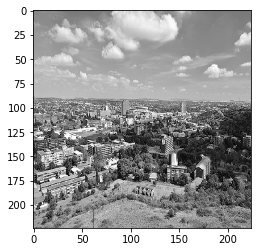

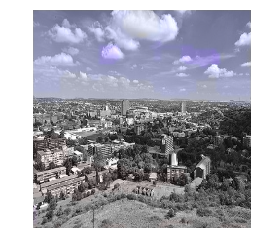

XMAX 55.378033807916864


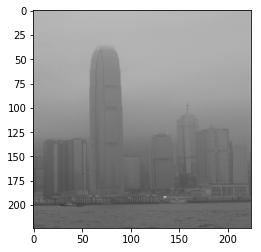

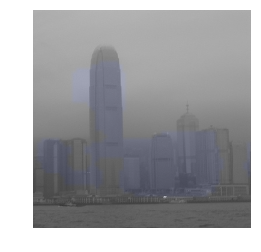

XMAX 81.569967823674


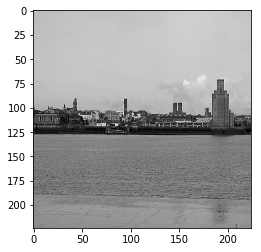

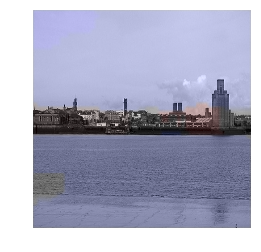

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 130.3992935961918


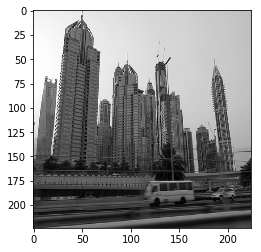

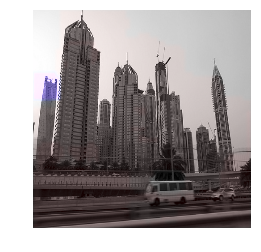

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 140.6268923620886


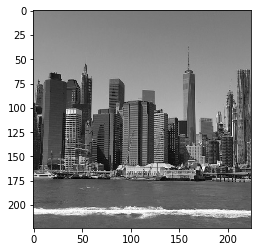

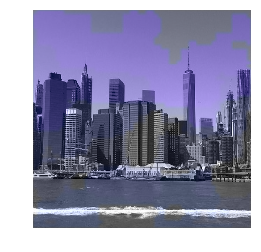

XMAX 132.09178829284167


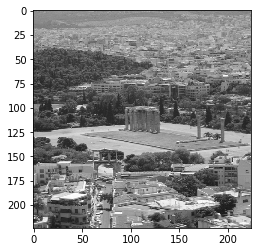

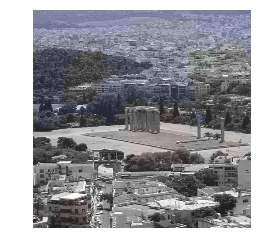

XMAX 76.15957567603438


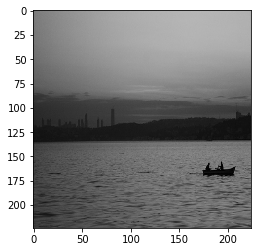

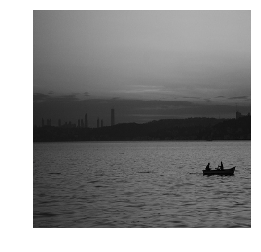

XMAX 83.96661896431557


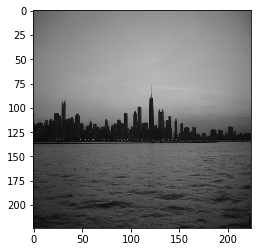

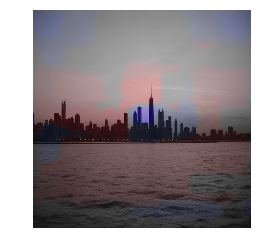

XMAX 128.70808396481638


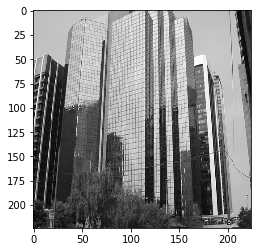

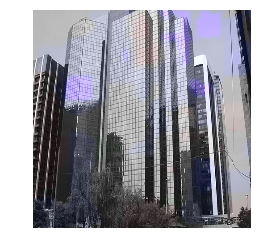

XMAX 107.54149466260074


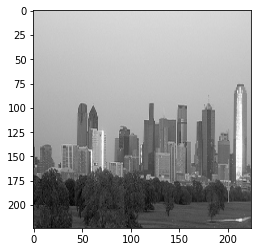

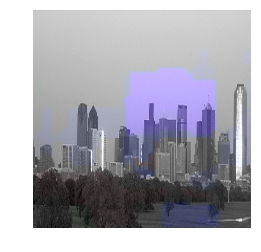

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 156.06660237620406


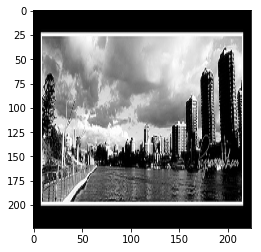

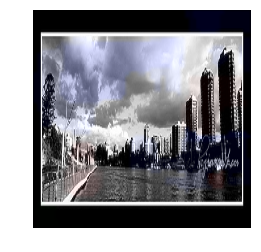

XMAX 142.5177350204305


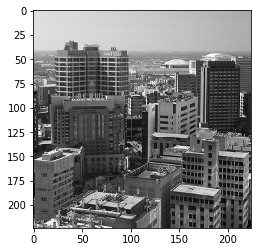

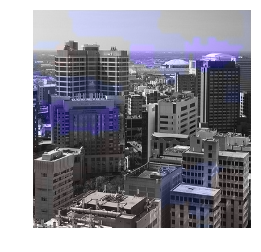

XMAX 220.98799007751785


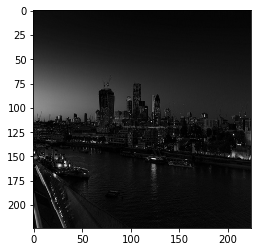

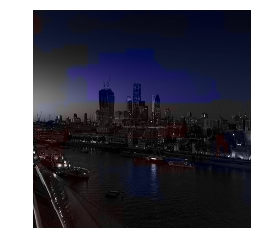

XMAX 92.13349726801573


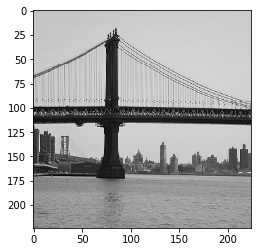

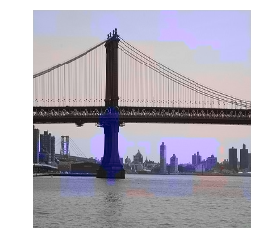

XMAX 110.58963414810472


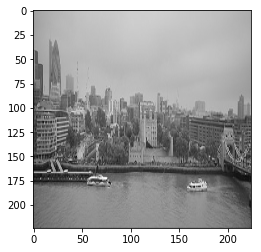

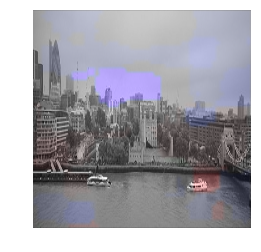

XMAX 108.89585455075101


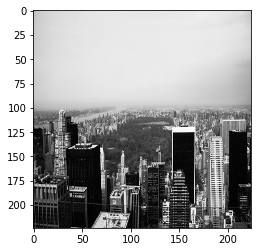

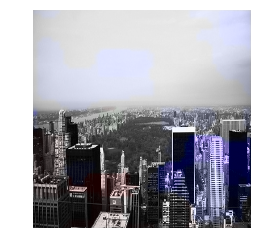

XMAX 103.7731933452691


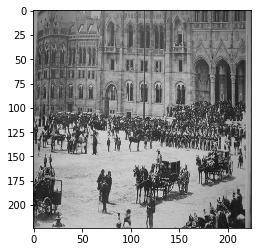

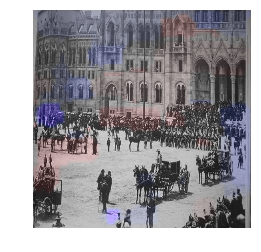

XMAX 93.10483755526681


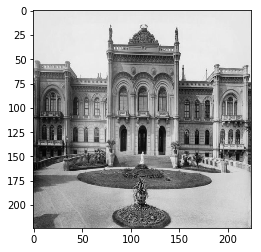

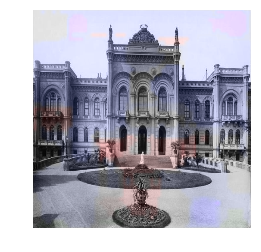

XMAX 98.2574557964129


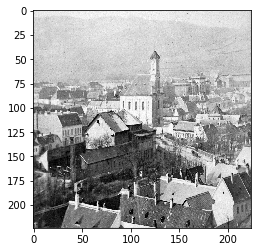

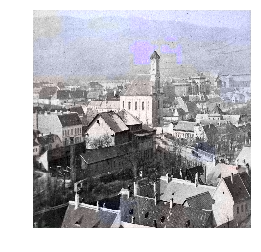

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


XMAX 179.64724657532022


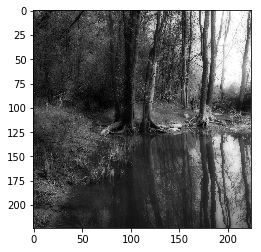

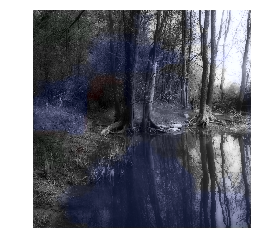

In [59]:
from matplotlib.pyplot import imshow
from skimage import color
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import transform, io, color

from importlib import reload  # Python 3.4+ only.
import streaming_data
streaming_data = reload(streaming_data)

watcher = streaming_data.StreamingDataGenerator(image_folder,batch_size=1, random_trf= False)

for idx in range(len(watcher)):
    X,Y = watcher[idx]
    print('XMAX', np.max(X))
    plt.imshow(watcher.gray_img[0]/255)
    plt.show()
    
    rgb_img = conc_pred(model, X, watcher)
    plt.imshow(rgb_img)
    plt.axis('off')
    plt.savefig(root_pictures + 'test_img'+str(idx)+'.png', bbox_inches='tight')
    plt.show()
    

In [52]:
def conc_pred(model, X, watcher, Y = None):
    y_real = model.predict(X)
    if (Y is not None):
        y_real = Y

    # Choose the a-b colors from the color classes.
    y_real = np.apply_along_axis(lambda x: watcher.pts_in_hull[np.argmax(x)], axis=3, arr = y_real)[0]

    lightness_3 = transform.resize( watcher.gray_img[0] , (56,56), preserve_range=True)
    
    lab_im = np.concatenate([lightness_3[:,:,0,np.newaxis]/255, y_real[:,:,0,np.newaxis],y_real[:,:,1,np.newaxis]], axis = 2)

    
    rgb_img = color.lab2rgb(lab_im)
    rgb_img = transform.resize( rgb_img , (224,224), preserve_range=True)
    
    lab_im = color.rgb2lab(rgb_img)
    lab_im = np.concatenate([watcher.gray_img[0,:,:,0,np.newaxis]/255*100, lab_im[:,:,1,np.newaxis],lab_im[:,:,2,np.newaxis]], axis = 2)

    rgb_img = color.lab2rgb(lab_im)
    return rgb_img

In [63]:
def create_plothistory(log_folder, save_location = None):
    history = pd.read_csv(log_folder)
    
    plt.figure()
    plt.plot(history['epoch'], history['acc']*100)
    plt.plot(history['epoch'], history['val_acc']*100)
    plt.title('model accuracy')
    plt.ylabel('accuracy in percent')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    if (save_location is not None):
        plt.savefig(save_location + 'model_accuracy.png')
    plt.show()
    
    plt.figure()
    # summarize history for loss
    plt.plot(history['epoch'], history['loss'])
    plt.plot(history['epoch'], history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    if (save_location is not None):
        plt.savefig(save_location + 'model_loss.png')
    plt.show() 

In [64]:
create_plothistory(log_path, saveplot_folder)

FileNotFoundError: File b'O:/ProgrammingSoftwares/anaconda_projects/dp_nagyhazi/tests/2/training1.log' does not exist

In [75]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        print(weights)
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

import numpy as np
from keras.activations import softmax
from keras.objectives import categorical_crossentropy

# init tests
samples=3
maxlen=4
vocab=5

y_pred_n = np.random.random((samples,maxlen,vocab,10)).astype(K.floatx())
y_pred = K.variable(y_pred_n)
print(y_pred_n)
y_pred = softmax(y_pred)

y_true_n = np.random.random((samples,maxlen,vocab,10)).astype(K.floatx())
y_true = K.variable(y_true_n)
y_true = softmax(y_true)

# test 1 that it works the same as categorical_crossentropy with weights of one
weights = np.ones(vocab)

loss_weighted=weighted_categorical_crossentropy(weights)(y_true,y_pred).eval(session=K.get_session())
loss=categorical_crossentropy(y_true,y_pred).eval(session=K.get_session())
np.testing.assert_almost_equal(loss_weighted,loss)
print('OK test1')




[[[[7.44143009e-01 6.89805508e-01 3.49655509e-01 5.06600738e-01
    1.97247282e-01 8.68867457e-01 3.81200075e-01 4.93015796e-02
    7.61171505e-02 4.71938491e-01]
   [6.08858407e-01 6.18716180e-01 3.22924042e-03 2.90904701e-01
    1.85117409e-01 4.85646576e-02 9.59328651e-01 3.81429911e-01
    2.54321784e-01 2.19593838e-01]
   [5.34965932e-01 7.90129840e-01 8.88609663e-02 6.41047299e-01
    1.33902386e-01 1.26448706e-01 3.85172606e-01 7.91769028e-01
    3.49194527e-01 8.96387696e-01]
   [5.95159233e-01 3.69668216e-01 7.17253506e-01 1.99178934e-01
    6.72600150e-01 5.93334317e-01 2.69845903e-01 1.57663539e-01
    8.34738910e-01 7.16936588e-01]
   [8.36849809e-01 4.61447865e-01 3.33547145e-01 1.13891286e-03
    4.54862090e-03 9.66819763e-01 1.23711362e-01 7.33987987e-01
    2.69653738e-01 3.76092225e-01]]

  [[1.09872386e-01 2.71131903e-01 4.49649870e-01 9.57305789e-01
    8.12042236e-01 8.85219812e-01 3.24108116e-02 3.30569297e-01
    2.35255405e-01 6.78370148e-02]
   [8.23992074e-01 1

ValueError: Dimensions must be equal, but are 10 and 5 for 'mul_24' (op: 'Mul') with input shapes: [3,4,5,10], [5].

In [76]:
softmax(np.random.random((samples,maxlen,vocab,10)).astype(K.floatx()))

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'